## <p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">MKT Analytics and Customer Segmentation</p>

This case study has the goal of implementing: a Cohort Analysis, a Recency, Frequency, and Monetary Value analysis, and finally Customer Segmentation on the data. [Link Here](https://archive.ics.uci.edu/ml/datasets/online+retail) 
Note that the data used in this notebook is a 20% sample of the data.





<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">LIST OF CONTENTS</p>   

    
* [1. Import Libraries](#1)
    
* [2. Loading the Data](#2)
    
* [3. Cohort Analysis](#3)
    
* [4. Recency, Frequency, and Monetary Value analysis](#4)
    
* [5. Data Preprocessing](#5)
    
* [6. Customer segmentation](#6)
    
* [7. Conclusions](#7)
    
* [8. Recommendations](#8)

<a id="1"></a>
<p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">IMPORT LIBRARIES</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

### Sklearn Modules

In [2]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

# Segmentation
from sklearn.cluster import KMeans

seed = 123

<a id="2"></a>
<p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">LOADING THE DATA</p>

In [3]:
online = pd.read_csv('online.csv', index_col=0)
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [4]:
online['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [5]:
online['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

**Observation:**
> The granularity of Date is 2 years for the analysis.

In [6]:
online.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
online.duplicated().sum()

239

In [8]:
online.drop_duplicates(inplace=True)
online.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70625 entries, 416792 to 312243
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    70625 non-null  int64         
 1   StockCode    70625 non-null  object        
 2   Description  70625 non-null  object        
 3   Quantity     70625 non-null  int64         
 4   InvoiceDate  70625 non-null  datetime64[ns]
 5   UnitPrice    70625 non-null  float64       
 6   CustomerID   70625 non-null  int64         
 7   Country      70625 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 4.8+ MB


In [9]:
online['InvoiceDate'].min(), online['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

<a id="3"></a>
<p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">COHORT ANALYSIS</p>

**`Cohort analysis` is a statistical technique used to analyze and compare groups of individuals who share a common characteristic over time. It is often used in business and marketing to understand customer behavior and to identify trends and patterns in how customers engage with a company or product.**

In [10]:
# Define a function that will parse the date
def get_month(x): return dt.datetime(x.year, x.month, 1) 

# Create InvoiceDay column
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month) 

# Group by CustomerID and select the InvoiceMonth value
online['CohortMonth'] = online.groupby('CustomerID')['InvoiceMonth'].transform('min')

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01


In [11]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, _ = get_date_int(online, 'InvoiceMonth')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, _ = get_date_int(online, 'CohortMonth')

In [12]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in days from all previous values
online['CohortIndex'] = years_diff * 12 + months_diff * 1
online['CohortMonth'] = online['CohortMonth'].apply(lambda x: x.strftime("%Y-%m"))
online['InvoiceMonth'] = online['InvoiceMonth'].apply(lambda x: x.strftime("%Y-%m"))

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10,2011-04,6
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11,2011-09,2
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07,2011-07,0
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11,2011-11,0
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05,2011-02,3


In [13]:
cohort_data = online.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_data.head()

,CohortMonth,CohortIndex,CustomerID
0,2010-12,0,716
1,2010-12,1,246
2,2010-12,2,221
3,2010-12,3,251
4,2010-12,4,245


In [14]:
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,716.0,246.0,221.0,251.0,245.0,285.0,249.0,236.0,240.0,265.0,254.0,348.0,172.0
2011-01,332.0,69.0,82.0,81.0,110.0,90.0,82.0,86.0,104.0,102.0,124.0,45.0,NaN
2011-02,316.0,58.0,57.0,83.0,85.0,74.0,80.0,83.0,86.0,95.0,28.0,NaN,NaN
2011-03,388.0,63.0,100.0,76.0,83.0,67.0,98.0,85.0,107.0,38.0,NaN,NaN,NaN
2011-04,255.0,49.0,52.0,49.0,47.0,52.0,56.0,59.0,17.0,NaN,NaN,NaN,NaN
2011-05,249.0,40.0,43.0,36.0,52.0,58.0,61.0,22.0,NaN,NaN,NaN,NaN,NaN
2011-06,207.0,33.0,26.0,41.0,49.0,62.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,173.0,28.0,31.0,38.0,44.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,139.0,30.0,28.0,35.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


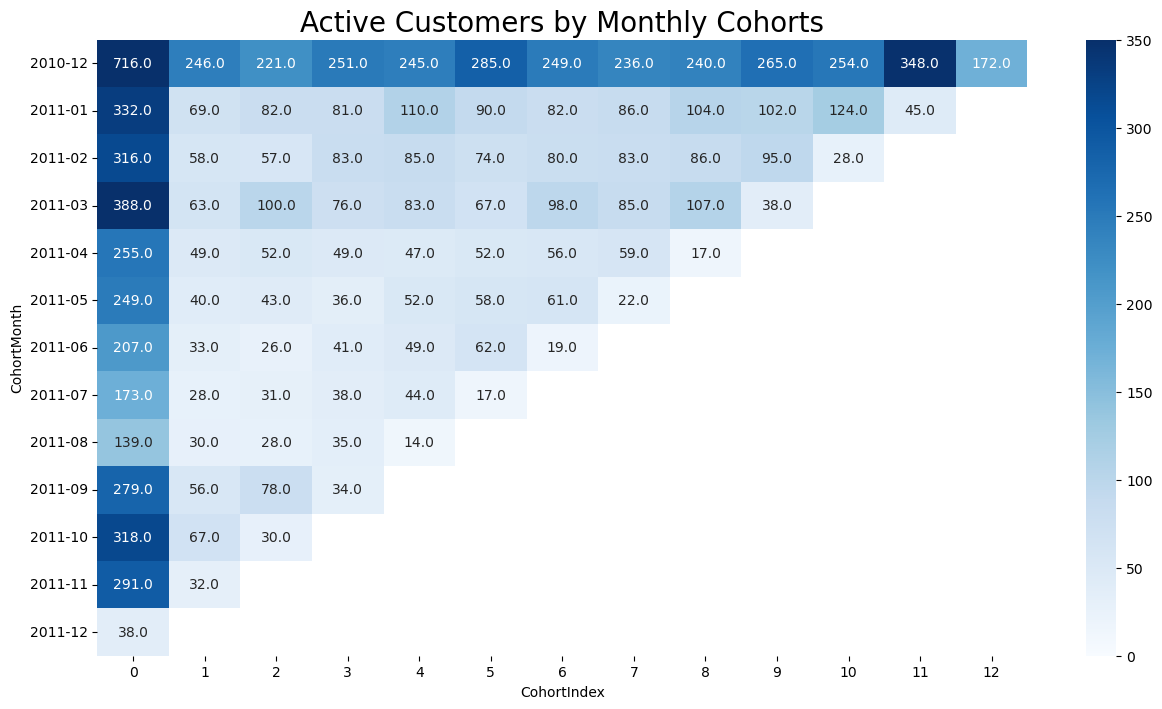

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(cohort_counts, annot=True, fmt='', vmin=0, vmax=350, cmap='Blues')
plt.title('Active Customers by Monthly Cohorts', size=20)
plt.show()

**Observation:**

> The company had the most customer on the eleven `11` month based on the 2 year data.

> However, most of the months got a decline in users from 2010 to 2011.

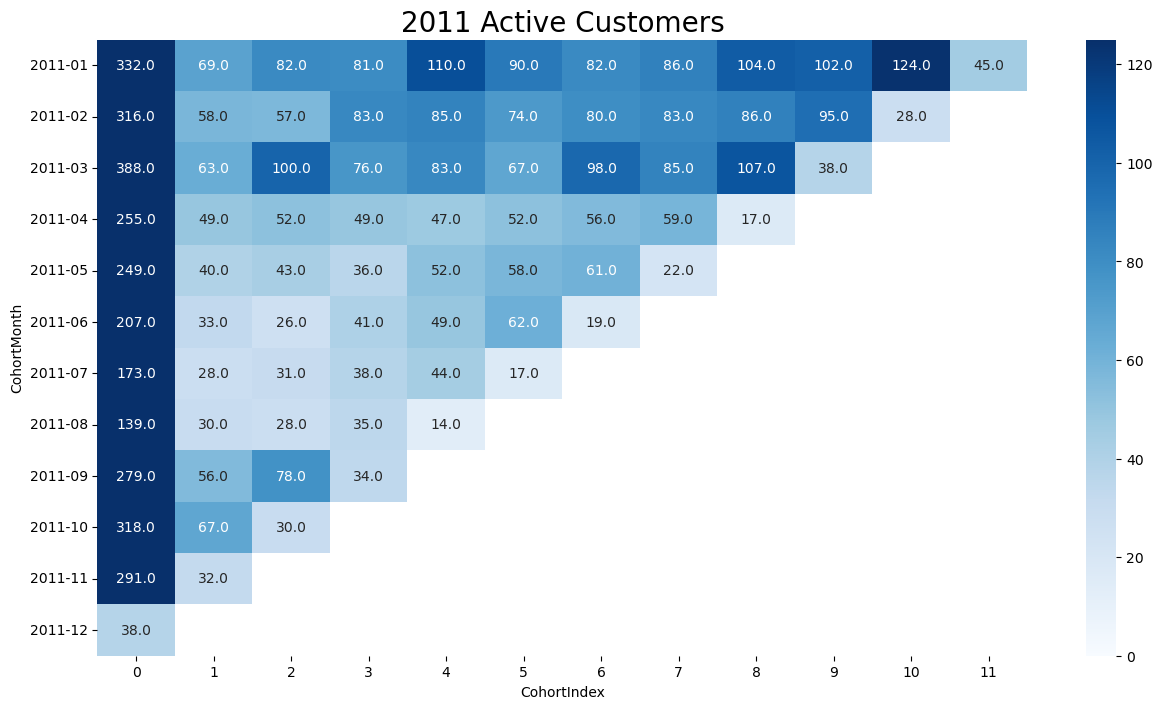

In [16]:
cohort_2011 = cohort_data[cohort_data['CohortMonth'] > "2010-12"]
cohort_counts_2011 = cohort_2011.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
plt.figure(figsize=(15,8))
sns.heatmap(cohort_counts_2011, annot=True, fmt='', vmin=0, vmax=125, cmap='Blues')
plt.title('2011 Active Customers', size=20)
plt.show()

**Observation:**
> In the 4th, 8th, 9th, and 10th month most of the users came back.

In [17]:
# Count the number of unique values per customer ID
cohort_data = online.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)

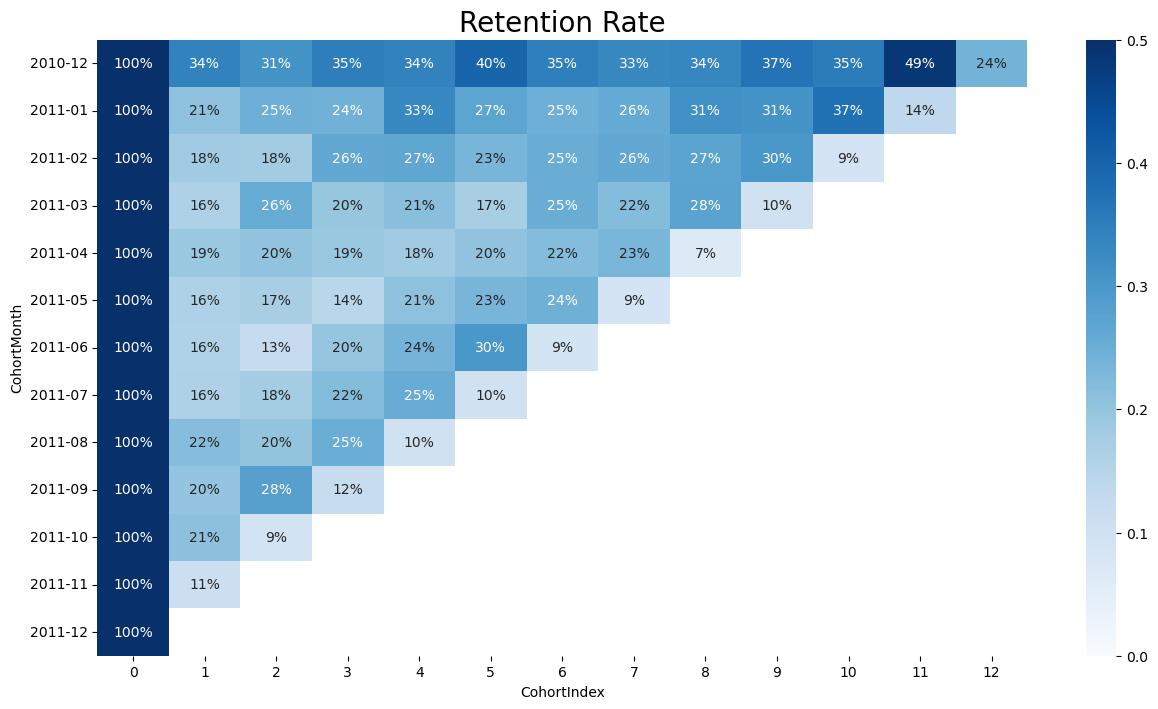

In [18]:
plt.figure(figsize=(15,8))
sns.heatmap(retention, annot=True, fmt='.0%', vmin=0, vmax=0.5, cmap='Blues')
plt.title('Retention Rate', size=20)
plt.show()

**Observation:**

> The highest retention rate was on the `11` month.

In [19]:
# Create a groupby object and pass the monthly cohort and unit price
cohort_data = online.groupby(['CohortMonth', 'CohortIndex'])['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')

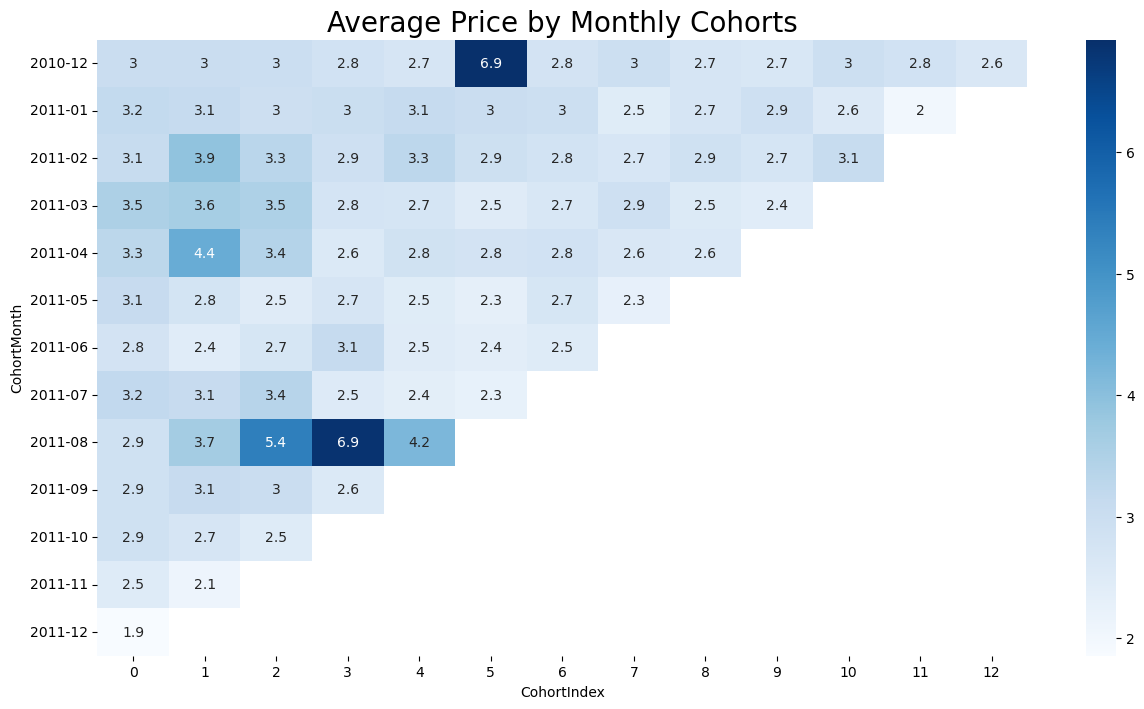

In [20]:
plt.figure(figsize=(15,8))
sns.heatmap(average_price, annot=True, cmap='Blues')
plt.title('Average Price by Monthly Cohorts', size=20)
plt.show()

**Observation:**

> In terms of price the highest average were on the `3` and `5` months.

<a id="4"></a>
<p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">RECENCY, FREQUENCY, AND MONETARY VALUE ANALYSIS</p>

**A Recency, Frequency and Monetary Value (RFM) analysis is a marketing technique that is used to identify the most valuable customers of a business. It is based on the idea that the value of a customer is determined by their recency, frequency, and monetary value.**

* `Recency`: Recency refers to the last time a customer made a purchase. Customers who have made a purchase recently are considered more valuable than those who have not made a purchase in a long time.

* `Frequency`: Frequency refers to the number of purchases a customer has made over a given time period. Customers who make frequent purchases are generally considered more valuable than those who make infrequent purchases.

* `Monetary Value`: Monetary Value refers to the total amount of money a customer has spent over a given time period. Customers who spend more money are generally considered more valuable than those who spend less.

In [21]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10,2011-04,6,12.60
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11,2011-09,2,1.45
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07,2011-07,0,22.50
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11,2011-11,0,2.10
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05,2011-02,3,17.85


In [22]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

print('Min:{}; Max:{}'.format(min(online.InvoiceDate), max(online.InvoiceDate)))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:49:00


In [23]:
# Calculate Recency, Frequency and Monetary value for each customer 
datamart_rfm = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns 
datamart_rfm.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

datamart_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,954,7463.07
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


**Observation:**

> We successfully calculated the Recency, Frequency and Monetary Value on the data. Now we are going to punctuate these columns in order to find the most valuable customers.

In [24]:
# Create labels for Recency and Frequency
r_labels = range(3, 0, -1)

f_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(datamart_rfm['Recency'], q=3, labels=r_labels)

# Assign these labels to three equal percentile groups 
f_groups = pd.qcut(datamart_rfm['Frequency'], q=3, labels=f_labels)

# Create new columns R and F 
datamart = datamart_rfm.assign(R=r_groups.values, F=f_groups.values)
datamart.head()

,Recency,Frequency,MonetaryValue,R,F
CustomerID,,,,,
12747,2,27,992.82,3,3
12748,1,954,7463.07,3,3
12749,4,37,813.45,3,3
12820,3,17,268.02,3,3
12822,71,9,146.15,2,2


In [25]:
# Create labels for MonetaryValue
m_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(datamart['MonetaryValue'], q=3, labels=m_labels)

# Create new column M
datamart = datamart.assign(M=m_groups.values)
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12747,2,27,992.82,3,3,3
12748,1,954,7463.07,3,3,3
12749,4,37,813.45,3,3,3
12820,3,17,268.02,3,3,3
12822,71,9,146.15,2,2,2


In [26]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

In [27]:
# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,27,992.82,3,3,3,333,9
12748,1,954,7463.07,3,3,3,333,9
12749,4,37,813.45,3,3,3,333,9
12820,3,17,268.02,3,3,3,333,9
12822,71,9,146.15,2,2,2,222,6


In [28]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 9)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12747,2,27,992.82,3,3,3,333,9,Top
12748,1,954,7463.07,3,3,3,333,9,Top
12749,4,37,813.45,3,3,3,333,9,Top
12820,3,17,268.02,3,3,3,333,9,Top
12822,71,9,146.15,2,2,2,222,6,Middle


In [29]:
datamart.sort_values('RFM_Score', ascending=False).head(20)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12747,2,27,992.82,3,3,3,333,9,Top
16938,9,52,426.31,3,3,3,333,9,Top
13534,2,63,1242.05,3,3,3,333,9,Top
13536,1,40,723.07,3,3,3,333,9,Top
17019,11,52,268.46,3,3,3,333,9,Top
17017,3,43,1324.16,3,3,3,333,9,Top
14336,17,17,342.82,3,3,3,333,9,Top
14329,17,46,967.28,3,3,3,333,9,Top
17001,1,34,722.45,3,3,3,333,9,Top


**Observation:** 

> Customers with top RFM_score are shown, these are the most valuable customer in terms of the analysis.

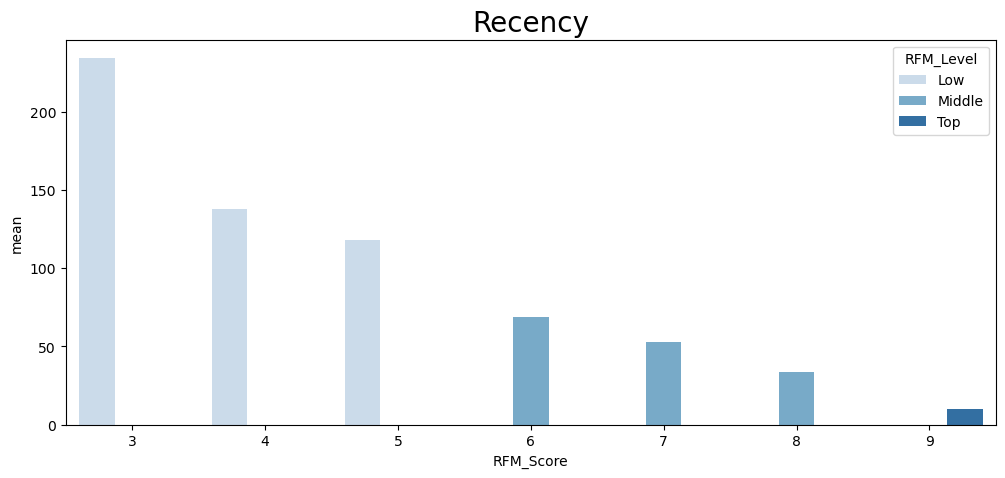

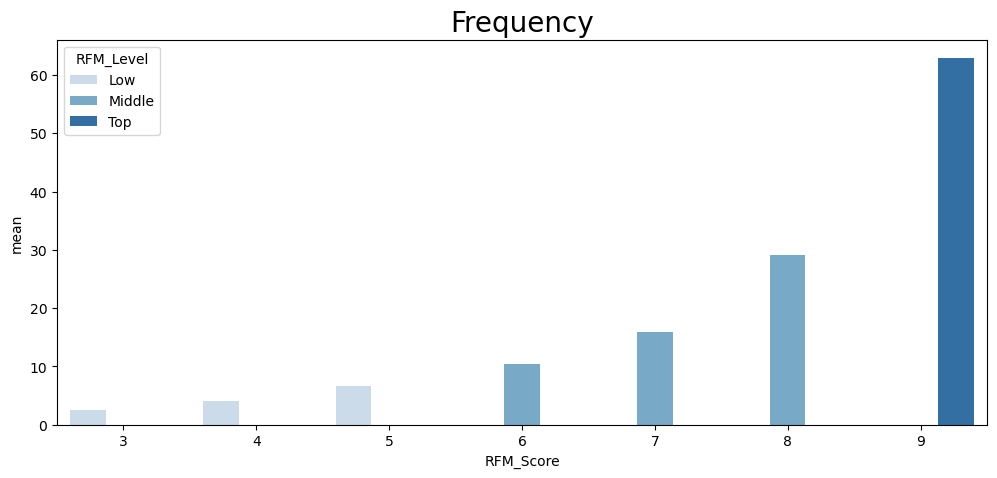

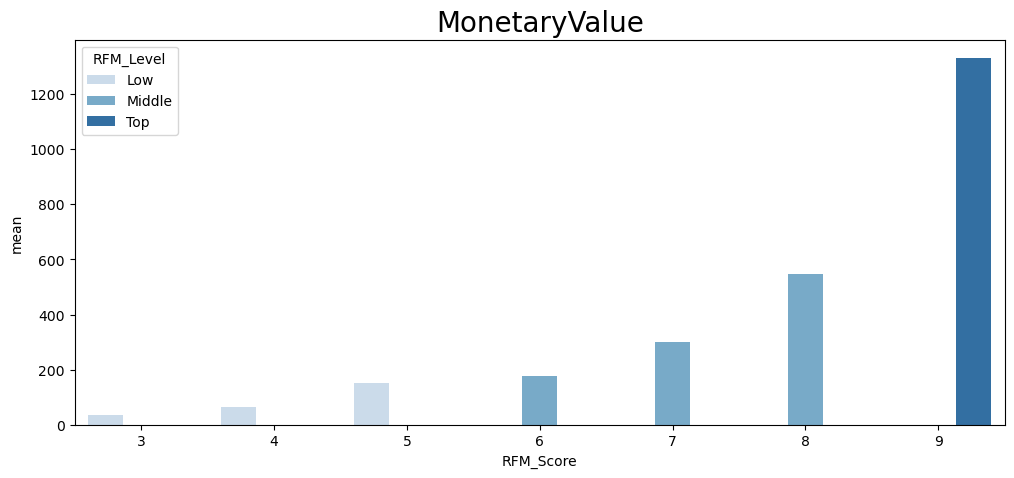

In [30]:
rfm_segment_agg = datamart.groupby(['RFM_Level', 'RFM_Score'], as_index=False).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean']
}).round(1)

plot = ['Recency', 'Frequency', 'MonetaryValue']
for i in plot:
    plt.figure(figsize=(12,5))
    sns.barplot(x='RFM_Score', y=rfm_segment_agg[i]['mean'], hue='RFM_Level', data=rfm_segment_agg, palette='Blues')
    plt.title(i, size=20)
    plt.show()

In [31]:
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean']
}).round(1)

# Print the aggregated dataset
rfm_level_agg

,Recency,Frequency,MonetaryValue
,mean,mean,mean
RFM_Level,,,
Low,161.8,4.5,86.8
Middle,52.1,18.3,337.5
Top,10.3,62.9,1330.7


**Observation:** 
> We can se the average Recency, Frequency and Monetary value of the three levels.

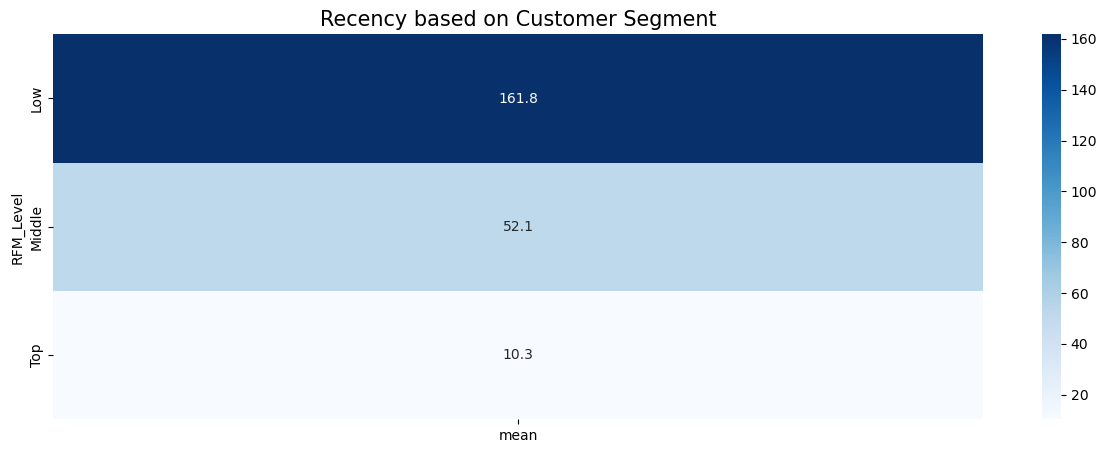

In [32]:
plt.figure(figsize=(15,5))
sns.heatmap(rfm_level_agg['Recency'], annot=True, fmt='', cmap='Blues')
plt.title('Recency based on Customer Segment', size=15)
plt.show()

**Observation:**

> Note that Top customer have the lowest Recency.

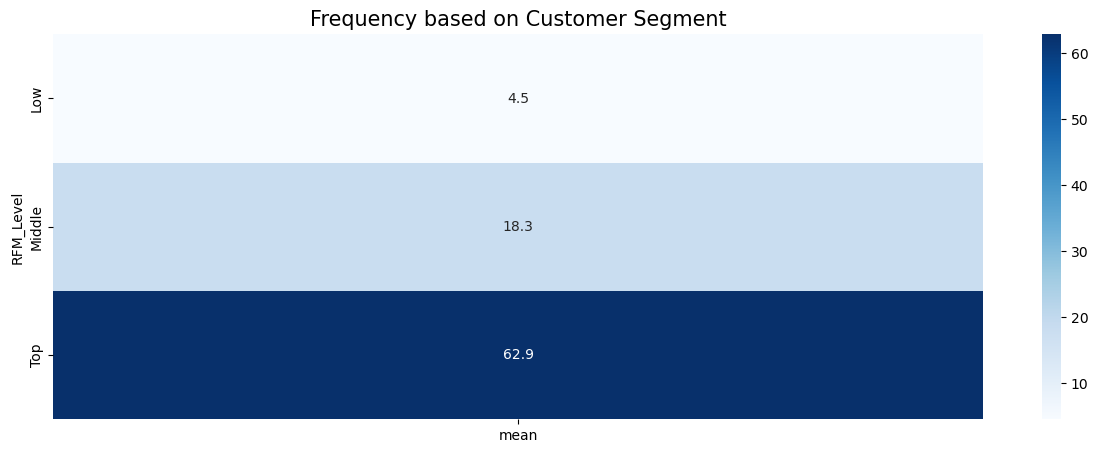

In [33]:
plt.figure(figsize=(15,5))
sns.heatmap(rfm_level_agg['Frequency'], annot=True, fmt='', cmap='Blues')
plt.title('Frequency based on Customer Segment', size=15)
plt.show()

**Observation:**

> Note that the top customers have the highest Frequency.

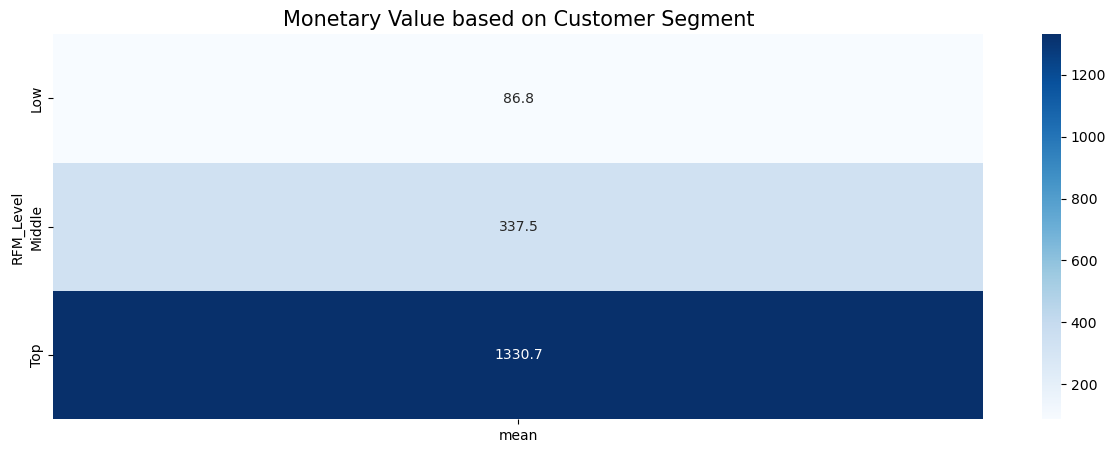

In [34]:
plt.figure(figsize=(15,5))
sns.heatmap(rfm_level_agg['MonetaryValue'], annot=True, fmt='', cmap='Blues')
plt.title('Monetary Value based on Customer Segment', size=15)
plt.show()

**Observation:**

> As expected top customers have the highest Monetary Value.

<a id="5"></a>
<p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DATA PREPROCESSING</p>

## Handling Distributions

In [35]:
datamart_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,954,7463.07
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


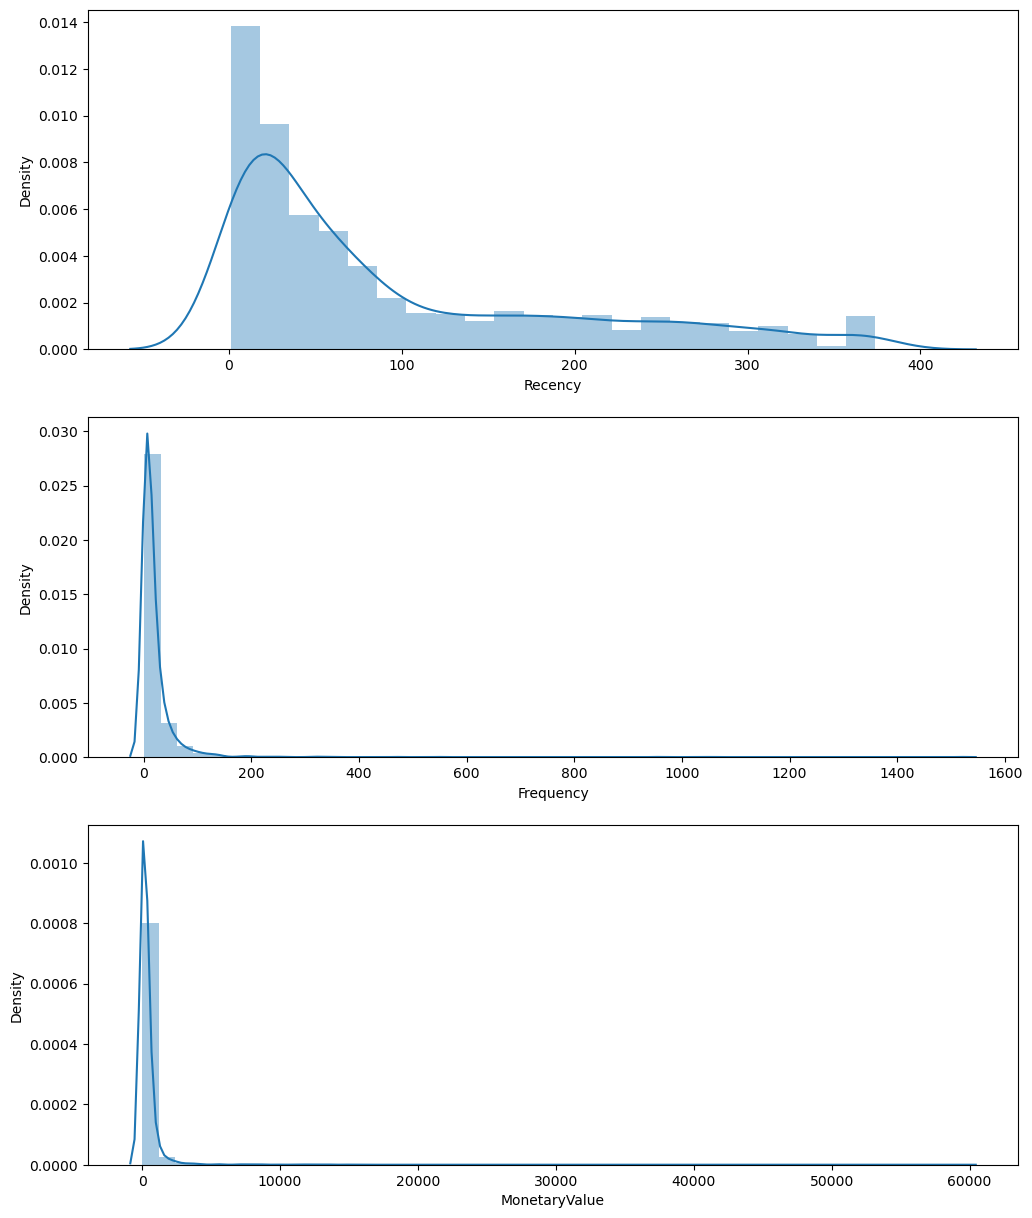

In [36]:
plt.figure(figsize=(12,15))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_rfm['MonetaryValue'])

# Show the plot
plt.show()

**Observation:**

> All the variables are right skewed, we are going to fix these variables for the preprocessing step. Kmeans needs input data normal distributed.

## Fixing Distributions and Normalizing

In [37]:
# Unskew the data
datamart_log = np.log(datamart_rfm)
datamart_log.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,0.693147,3.295837,6.900549
12748,0.000000,6.860664,8.917722
12749,1.386294,3.610918,6.701284
12820,1.098612,2.833213,5.591062
12822,4.262680,2.197225,4.984633


In [38]:
# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_log.index, columns=datamart_log.columns)
datamart_normalized.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,-2.195642,0.912224,1.483547
12748,-2.684553,3.839913,3.016710
12749,-1.706731,1.170991,1.332095
12820,-1.909647,0.532285,0.488264
12822,0.322128,0.009966,0.027345


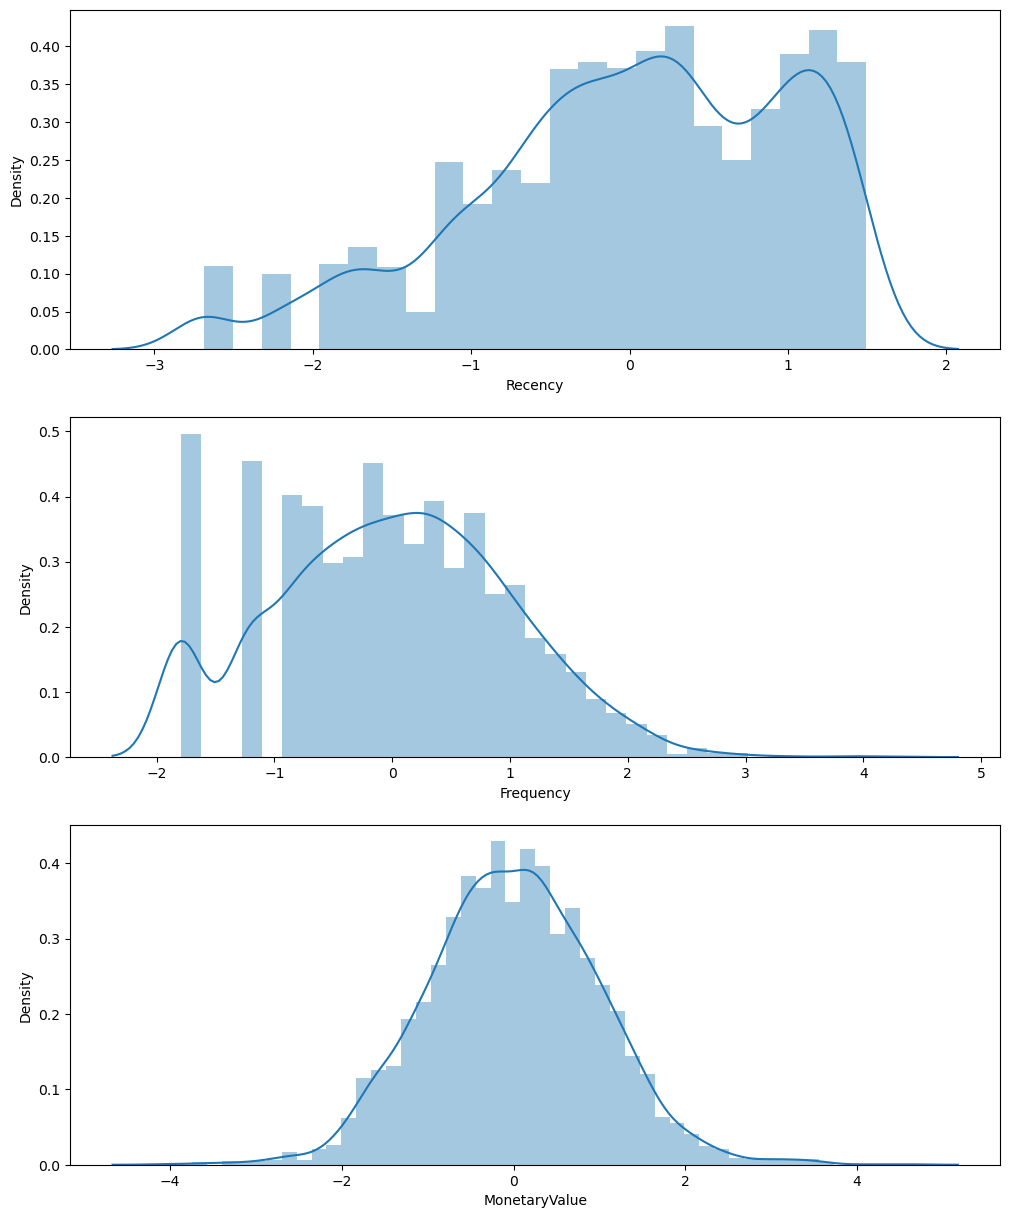

In [39]:
plt.figure(figsize=(12,15))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

<a id="6"></a>
<p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">CUSTOMER SEGMENTATION</p>

**The goal of `Customer Segmentation` is to better understand the needs and preferences of different groups of customers and to tailor marketing and product development efforts to meet these needs.**

**In this case `Clustering`, Clustering is a method of customer segmentation that involves grouping customers into clusters based on shared characteristics. Clustering algorithms use statistical techniques to identify patterns and relationships in customer data, and to group customers into clusters based on these patterns. Now, let's find them!**


For this, we are going to use the data of the previous analysis called `datamart_rfm`.

## Kmeans Model

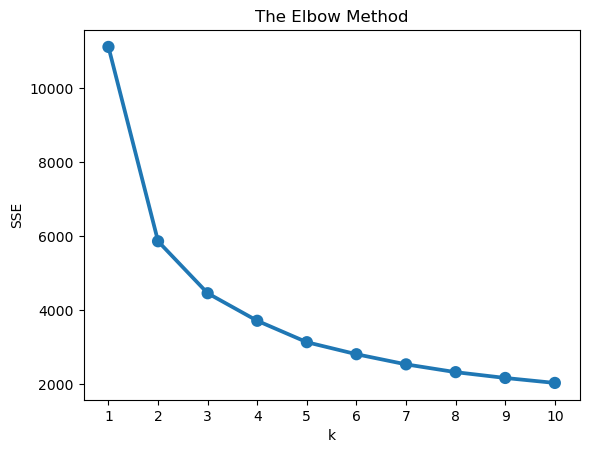

In [40]:
sse = {}

# Fit KMeans and calculate SSE for each k between 1 and 10
for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_   

# Add the plot title, x and y axis labels
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

**Observation:**

> The optimal n_clusters is `3`.

In [41]:
# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=seed) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         13.81     52.49       1127.27   855
1        171.48      3.12         55.23  1226
2         78.37     13.53        231.99  1620

In [42]:
datamart_normalized = pd.DataFrame(datamart_normalized, index=datamart_rfm.index, columns = datamart_rfm.columns)
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']
datamart_normalized.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12747,-2.195642,0.912224,1.483547,0
12748,-2.684553,3.839913,3.016710,0
12749,-1.706731,1.170991,1.332095,0
12820,-1.909647,0.532285,0.488264,0
12822,0.322128,0.009966,0.027345,2


## Snake Plot

In [43]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(
                        datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                        id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                        value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                        var_name='Metric', value_name='Value'
                        )
datamart_melt.head()

,CustomerID,Cluster,Metric,Value
0,12747,0,Recency,-2.195642
1,12748,0,Recency,-2.684553
2,12749,0,Recency,-1.706731
3,12820,0,Recency,-1.909647
4,12822,2,Recency,0.322128


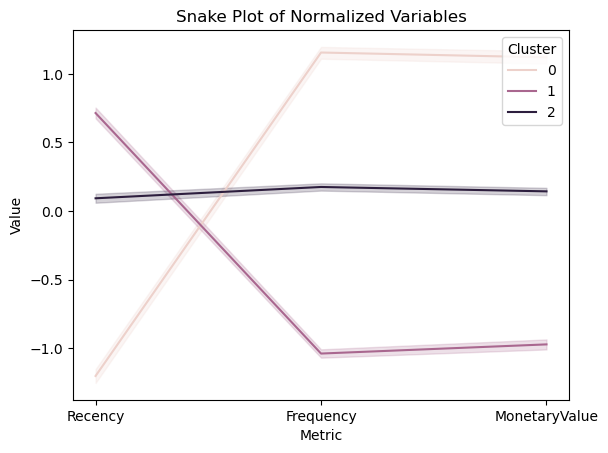

In [44]:
# Add the plot title
plt.title('Snake Plot of Normalized Variables')

# Add the x axis label
plt.xlabel('')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

**Observation:**

> Note that `Cluster 2` is has values very balanced values. This can be used to make customer personas.

## Calculating relative importance of each attribute

In [45]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.85,1.75,1.96
1,0.82,-0.84,-0.85
2,-0.17,-0.29,-0.39


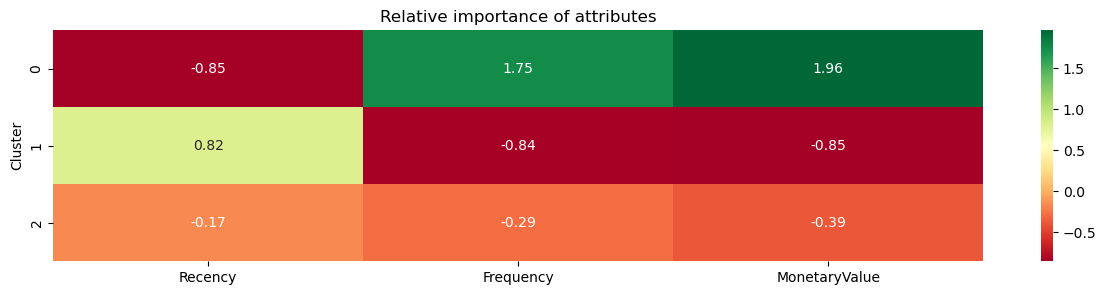

In [46]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(15, 3))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

**Observation:**

> Cluster 0 has the highest relative importances in `Frequency` and `Monetary Value`.

> Cluster 1 has the highest value in terms of `Recency`.

<a id="7"></a>
<p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">CONCLUSIONS</p>

**After making these three analysis we can conclude that:**

1. `Cluster 0`: It has the profile of the `Top` RFM_level labeled customers as in the RFM analysis. This does make sense because top customer have the characteristics of low recency, high frequency, and high monetary value.

2. `Cluster 1`: They make sense with `Low` RFM_level because they have the characteristics of high recency, low frequency, and low monetary value.

3. `Cluster 2`: It make sense with `Middle` RFM_level, customer that have moderate recency, moderate frequency, and low monetary value.

<a id="8"></a>
<p style="background-color:#1e3f5a;font-family:Lucida Grande;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">RECOMMENDATIONS</p>

1. Gather data of customer demographics, in this way, maybe we can find more interesting insights in terms of customer characteristics.